<a href="https://colab.research.google.com/github/UN-GCPDS/curso_IA_CHEC/blob/main/Modulo2/cuadernos/Conglomerados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

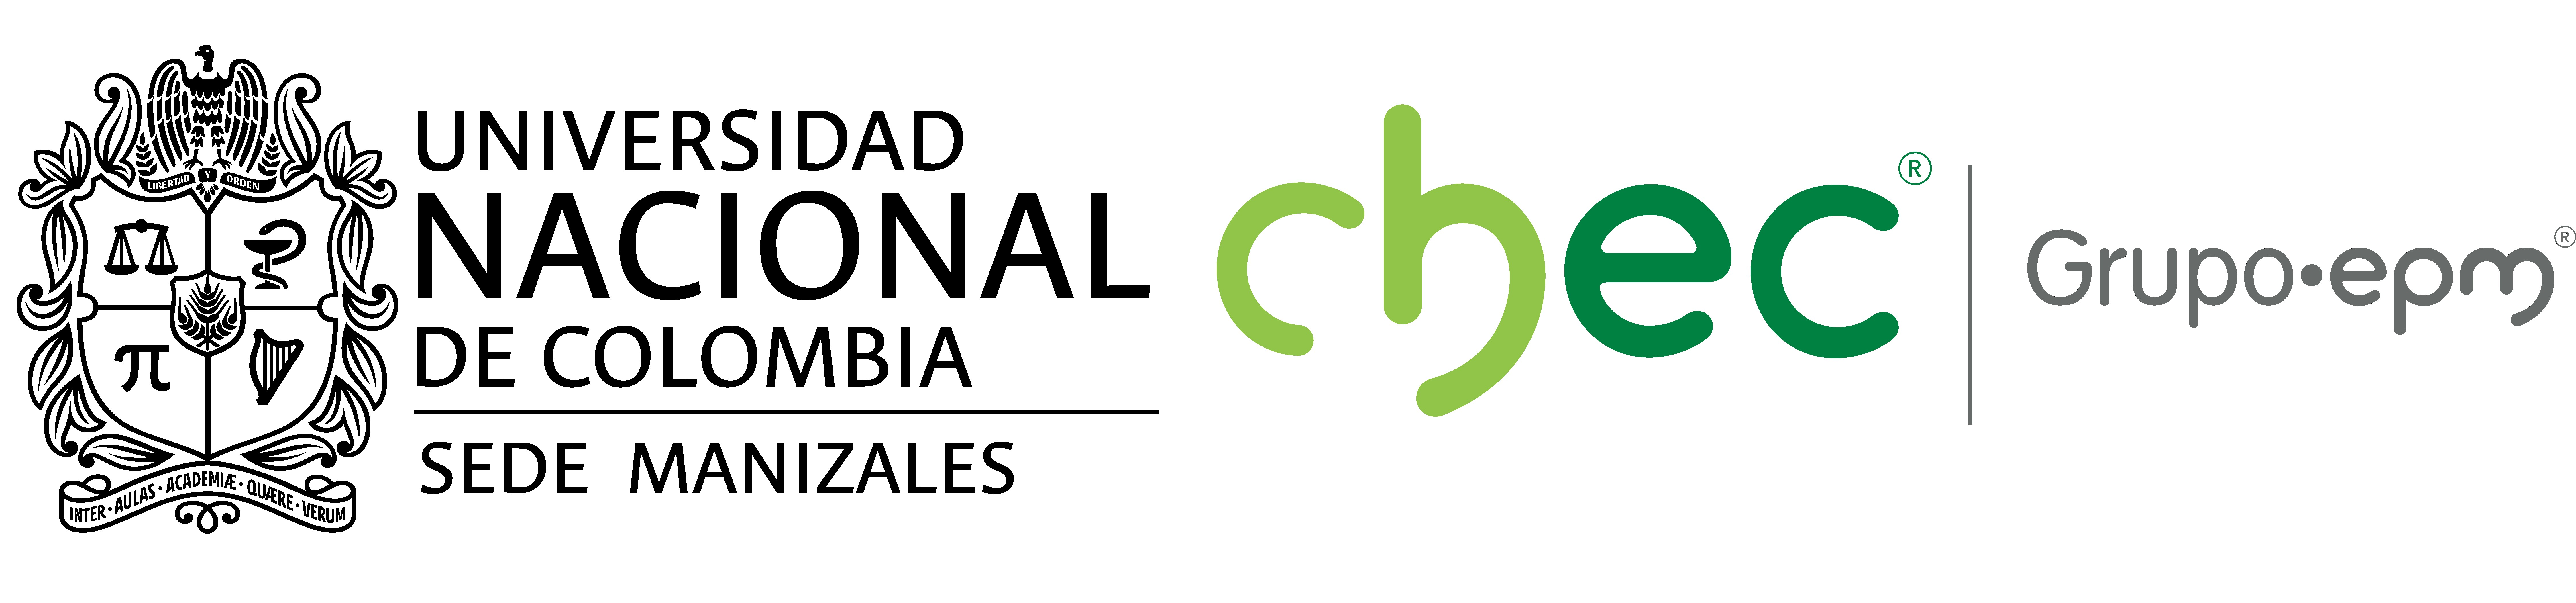
# **MÓDULO 2: Aprendizaje supervisado no supervisado **

## **Descripción**

Aplicación de modelos de aprendizaje de máquina para el estudio de datos tabulares por métodos supervisados y no supervisados.

### **Profesor - Sesión 1 y 2:** Diego Armando Pérez Rosero
### **Monitores - Sesión 1 y 2:** Danna Valentina Salazar Dubois, Juan Camilo Lugo Rojas y Lucas Miguel Iturriago Salas

#Conglomerados

In [1]:
# @title Importación de Librerías
# Widgets interactivos y visualizaciones

FILEID ="1XZCVLOZuejD0eJxlQGOW5EwkC1LaJWvp"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Vegetacion.jpg && rm -rf /tmp/cookies.txt
!dir

from ipywidgets import interact, FloatSlider, IntSlider, Dropdown, Button, VBox, Layout, Output, Text, HBox, interactive_output
from IPython.display import display, clear_output

# Visualización
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.pyplot import imread

# Procesamiento de datos y machine learning
import numpy as np
from sklearn.datasets import load_iris, make_blobs, make_moons, load_digits
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Otras utilidades
import os
from tempfile import mkdtemp
import os.path as path
import cv2
from timeit import timeit

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras

--2024-10-03 03:37:43--  https://docs.google.com/uc?export=download&confirm=&id=1XZCVLOZuejD0eJxlQGOW5EwkC1LaJWvp
Resolving docs.google.com (docs.google.com)... 142.250.152.113, 142.250.152.139, 142.250.152.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.152.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1XZCVLOZuejD0eJxlQGOW5EwkC1LaJWvp&export=download [following]
--2024-10-03 03:37:43--  https://drive.usercontent.google.com/download?id=1XZCVLOZuejD0eJxlQGOW5EwkC1LaJWvp&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.201.132, 2607:f8b0:4001:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.201.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13182200 (13M) [image/jpeg]
Saving to: ‘Vegetacion.jpg’

Vegetacion.jpg      100%[===================>]  12.57M  81.3MB/s    in

Clustering

- Se presentan los conceptos básicos de aprendizaje no supervisado mediante nociones de disimilitud y similitud.

**Ejemplo:** Consideremos el conjunto de datos *iris dataset*, donde la especie de cada instancia (es decir, su clase) se representa con un marcador diferente:

In [2]:
# @title Iris dataset
data = load_iris()
X = data.data
y = data.target

# Función para graficar con índices ajustables
def plot_iris(feature_x, feature_y):
    plt.figure(figsize=(9, 3.5))

    # Primer gráfico
    plt.subplot(121)
    plt.plot(X[y == 0, feature_x], X[y == 0, feature_y], "yo", label="Iris setosa")
    plt.plot(X[y == 1, feature_x], X[y == 1, feature_y], "bs", label="Iris versicolor")
    plt.plot(X[y == 2, feature_x], X[y == 2, feature_y], "g^", label="Iris virginica")
    plt.xlabel(data.feature_names[feature_x], fontsize=14)
    plt.ylabel(data.feature_names[feature_y], fontsize=14)
    plt.legend(fontsize=12)

    # Segundo gráfico
    plt.subplot(122)
    plt.scatter(X[:, feature_x], X[:, feature_y], c="k", marker=".")
    plt.xlabel(data.feature_names[feature_x], fontsize=14)
    plt.tick_params(labelleft=False)
    plt.tight_layout()
    plt.show()
# Uso de interact con sliders para seleccionar las características a graficar
interact(plot_iris,feature_x=IntSlider(min=0, max=3, step=1, value=2, description='Feature X'),
         feature_y=IntSlider(min=0, max=3, step=1, value=3, description='Feature Y'))


interactive(children=(IntSlider(value=2, description='Feature X', max=3), IntSlider(value=3, description='Feat…

<function __main__.plot_iris(feature_x, feature_y)>

- **Figura de la izquierda:** Es un conjunto de datos etiquetado, para el cual los algoritmos de clasificación como Regresión logística, SVM o clasificadores de bosque aleatorio son muy adecuados.
- **Figura de la derecha:** Tenemos el mismo conjunto de datos, pero sin las etiquetas, por lo que ya no puede usar un algoritmo de clasificación.

- Los algoritmos de conglomerados (clustering) buscan extraer grupos homogeneos de datos usando solo las características de entrada.

- **NOTA:** No existe una definición universal de lo que es un *clúster*: depende del contexto, diferentes algoritmos capturarán diferentes tipos de clústeres.

- Algunos algoritmos buscan instancias centradas alrededor de un punto particular, llamado *centroide*. Otros buscan *regiones continuas de instancias densamente empaquetadas*: estos grupos pueden tomar cualquier forma.

## K-means

Dado un conjunto de datos no supervisado:
\begin{equation}
X = \{ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n \}, \quad \mathbf{x}_i \in \mathbb{R}^P
\end{equation}

El problema de optimización del algoritmo K-means, para agrupar los datos de entrada en $K$ grupos disjuntos, se puede definir como:

\begin{align}
\hat{\boldsymbol{\mu}}_k =& \arg\min_{\boldsymbol{\mu}_k} \sum_{k=1}^{K} \sum_{\mathbf{x} \in C_k} \|\mathbf{x} - \boldsymbol{\mu}_k\|^2\\
\text{s.t.} & \quad C_k = \left\{\mathbf{x}_n : k=\min_{j}\|\mathbf{x} - \boldsymbol{\mu}_k\|\right\} \\
& \quad C_k \cap C_{k'} = \emptyset
\end{align}

donde el centro se define como:

\begin{equation}
\boldsymbol{\mu}_k = \frac{1}{|C_k|} \sum_{\mathbf{x} \in C_k} \mathbf{x}
\end{equation}

Y la actualización de los mismos depende de:

\begin{equation}
\boldsymbol{\mu}_k^{(t+1)} = \frac{1}{|C_k^{(t)}|} \sum_{\mathbf{x} \in C_k^{(t)}} \mathbf{x}
\end{equation}

**Ejemplo:** Consideremos un conjunto de datos sin etiqueta representado por $5$ *blobs* de instancias/muestras.

In [3]:
# @title Datos de prueba
# Inicialización de los centros y desviaciones estándar por defecto
initial_blob_centers = np.array(
    [[0.6,  2.3],
     [-1.5,  2.3],
     [-2.8,  2],
     [-2.8, 2.8],
     [-2.8, 1.3]]
)
initial_blob_std = [0.25, 0.15, 0.15, 0.15, 0.15]

class BlobVisualizer:
    def __init__(self, centers, std):
        self.centers = centers
        self.std = std
        self.X = None
        self.y = None

    def plot_clusters(self, n_samples, std1, std2, std3, std4, std5):
        self.std = [std1, std2, std3, std4, std5]
        self.X, self.y = make_blobs(n_samples=n_samples, centers=self.centers, cluster_std=self.std)

        plt.figure(figsize=(8, 4))
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=1)
        plt.xlabel("$x_1$", fontsize=14)
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
        plt.show()

# Instanciar la clase
visualizer = BlobVisualizer(initial_blob_centers, initial_blob_std)

# Uso de interact con la instancia del visualizador
interact(visualizer.plot_clusters,
         n_samples=IntSlider(min=100, max=5000, step=100, value=2000, description='Samples:'),
         std1=FloatSlider(min=0.05, max=1.0, step=0.05, value=initial_blob_std[0], description='Std 1:'),
         std2=FloatSlider(min=0.05, max=1.0, step=0.05, value=initial_blob_std[1], description='Std 2:'),
         std3=FloatSlider(min=0.05, max=1.0, step=0.05, value=initial_blob_std[2], description='Std 3:'),
         std4=FloatSlider(min=0.05, max=1.0, step=0.05, value=initial_blob_std[3], description='Std 4:'),
         std5=FloatSlider(min=0.05, max=1.0, step=0.05, value=initial_blob_std[4], description='Std 5:'))

interactive(children=(IntSlider(value=2000, description='Samples:', max=5000, min=100, step=100), FloatSlider(…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### Ajuste y predicción

- Vamos a entrenar un *clustering K-Means* en este conjunto de datos.

- **Intentaremos encontrar el centro de cada *blob* y asignar cada instancia al *blob* más cercano**:

Tracemos los **límites de decisión del modelo**. Esto nos da un *diagrama de Voronoi*:

In [4]:
X = visualizer.X
y = visualizer.y

In [5]:
# @title Algoritmo KMeans

class KMeansInteractive:
    def __init__(self, X):
        self.X = X
        self.kmeans = None
        self.y_pred = None
        self.output = Output()  # Output widget para los gráficos

    def train_kmeans(self, n_clusters, init_method, n_init, max_iter, algorithm):
        with self.output:
            clear_output(wait=True)  # Limpia la salida antes de mostrar nuevos resultados
            self.kmeans = KMeans(
                n_clusters=n_clusters,
                init=init_method,
                n_init=n_init,
                max_iter=max_iter,
                algorithm=algorithm,
                random_state=42
            )
            self.kmeans.fit(self.X)
            self.y_pred = self.kmeans.predict(self.X)
            self.plot_decision_boundaries()

    def plot_decision_boundaries(self):
        plt.figure(figsize=(8, 4))
        mins = self.X.min(axis=0) - 1
        maxs = self.X.max(axis=0) + 1
        xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000), np.linspace(mins[1], maxs[1], 1000))
        Z = self.kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.3, cmap="Pastel2")
        plt.contour(xx, yy, Z, linewidths=1, colors='k')
        self.plot_data()
        self.plot_centroids()
        plt.xlabel("$x_1$", fontsize=14)
        plt.ylabel("$x_2$", fontsize=14)
        plt.show()
        print(X.shape)

    def plot_data(self):
        plt.plot(self.X[:, 0], self.X[:, 1], 'k.', markersize=2)

    def plot_centroids(self):
        centroids = self.kmeans.cluster_centers_
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=30, linewidths=8,
                    color='w', zorder=10, alpha=0.9)
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=50, linewidths=3,
                    color='k', zorder=11, alpha=1)

# Widgets para los hiperparámetros
n_clusters_slider = IntSlider(min=2, max=10, step=1, value=5, description='n_clusters:', style={'description_width': 'initial'})
init_dropdown = Dropdown(options=['k-means++', 'random'], value='random', description='Init Method:', style={'description_width': 'initial'})
n_init_slider = IntSlider(min=1, max=20, step=1, value=4, description='n_init:', style={'description_width': 'initial'})
max_iter_slider = IntSlider(min=1, max=1000, step=1, value=5, description='max_iter:', style={'description_width': 'initial'})
algorithm_dropdown = Dropdown(options=['lloyd', 'elkan'], value='lloyd', description='Algorithm:', style={'description_width': 'initial'})

train_button = Button(description="Train KMeans")
kmeans_interactive = KMeansInteractive(X)  # Instancia de la clase

def on_train_button_clicked(b):
    kmeans_interactive.train_kmeans(
        n_clusters_slider.value, init_dropdown.value,
        n_init_slider.value, max_iter_slider.value, algorithm_dropdown.value
    )

train_button.on_click(on_train_button_clicked)
ui = VBox([n_clusters_slider, init_dropdown, n_init_slider, max_iter_slider, algorithm_dropdown, train_button],
          layout=Layout(display='flex', flex_flow='column', align_items='stretch'))
display(ui, kmeans_interactive.output)


Output()

- Tengamos en cuenta que debemos especificar el número de clústeres $k$ que debe encontrar el algoritmo.

- En este caso, cada instancia fue asignada a uno de los 5 grupos.

- En el contexto de la agrupación, **la etiqueta de una instancia es el índice de la agrupación a la que el algoritmo asigna esta instancia**.

- No debe confundirse con las etiquetas de clase en clasificación.

- *KMeans* conserva una copia de las etiquetas de las instancias en las que se entrenó, disponible a través de la variable *labels_ instance*:

In [6]:
kmeans_good=kmeans_interactive.kmeans
kmeans_good_=kmeans_interactive

In [7]:
kmeans=kmeans_interactive.kmeans
y_pred=kmeans.predict(X)
y_pred

array([5, 4, 1, ..., 2, 3, 2], dtype=int32)

In [8]:
kmeans.labels_

array([5, 4, 1, ..., 2, 3, 2], dtype=int32)

También podemos echar un vistazo a los 5 centroides que encontró el algoritmo:

In [9]:
kmeans.cluster_centers_

array([[-1.54090098,  2.32251019],
       [-2.79915986,  2.0001337 ],
       [ 0.57695319,  2.26082818],
       [-2.79354482,  2.83541202],
       [-2.79889253,  1.29951138],
       [-2.81298606,  2.75723087],
       [-1.46625079,  2.28461566],
       [ 0.62189135,  2.32421033]])

Por supuesto, podemos asignar fácilmente nuevas instancias al clúster cuyo centroide es el más cercano:

In [10]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([2, 7, 3, 5], dtype=int32)

- La gran mayoría de las instancias estan claramente asignadas al grupo apropiado,**pero algunas instancias probablemente estaban mal etiquetadas** (especialmente cerca del límite entre el grupo superior izquierdo y el grupo central).
- De hecho, el algoritmo **K-Means no se comporta muy bien cuando los *blobs* tienen diámetros muy diferentes**, ya que lo único que le importa al asignar una instancia a un clúster es la distancia al centro.

### K-Means

**El algoritmo en acción:**

- La clase *KMeans* aplica un algoritmo optimizado por defecto. Para obtener el algoritmo K-Means original (solo con fines educativos), debe establecer *init="random"*, *n_init = 1* and *algorithm="full"*. Estos hiperparámetros se explicarán a continuación.

- Ejecutemos el algoritmo K-Means para 1, 2 y 3 iteraciones, para ver **cómo se mueven los centroides**:

In [11]:
# @title K-Means original
X = visualizer.X
y = visualizer.y

class KMeansInteractive:
    def __init__(self, X):
        self.X = X
        self.kmeans = None
        self.y_pred = None
        self.output = Output()  # Output widget para los gráficos

    def train_kmeans(self, n_clusters, init_method, n_init, max_iter, algorithm):
        with self.output:
            clear_output(wait=True)  # Limpia la salida antes de mostrar nuevos resultados
            self.kmeans = KMeans(
                n_clusters=n_clusters,
                init=init_method,
                n_init=n_init,
                max_iter=max_iter,
                algorithm=algorithm,
                random_state=42
            )
            self.kmeans.fit(self.X)
            self.y_pred = self.kmeans.predict(self.X)
            self.plot_decision_boundaries()

    def plot_decision_boundaries(self):
        plt.figure(figsize=(8, 4))
        mins = self.X.min(axis=0) - 1
        maxs = self.X.max(axis=0) + 1
        xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000), np.linspace(mins[1], maxs[1], 1000))
        Z = self.kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.3, cmap="Pastel2")
        plt.contour(xx, yy, Z, linewidths=1, colors='k')
        self.plot_data()
        self.plot_centroids()
        plt.xlabel("$x_1$", fontsize=14)
        plt.ylabel("$x_2$", fontsize=14)
        plt.show()
        print(X.shape)

    def plot_data(self):
        plt.plot(self.X[:, 0], self.X[:, 1], 'k.', markersize=2)

    def plot_centroids(self):
        centroids = self.kmeans.cluster_centers_
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=30, linewidths=8,
                    color='w', zorder=10, alpha=0.9)
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=50, linewidths=3,
                    color='k', zorder=11, alpha=1)

# Widgets para los hiperparámetros
n_clusters_slider = IntSlider(min=2, max=10, step=1, value=2, description='n_clusters:', style={'description_width': 'initial'})
init_dropdown = Dropdown(options=['k-means++', 'random'], value='random', description='Init Method:', style={'description_width': 'initial'})
n_init_slider = IntSlider(min=1, max=20, step=1, value=1, description='n_init:', style={'description_width': 'initial'})
max_iter_slider = IntSlider(min=1, max=1000, step=1, value=1, description='max_iter:', style={'description_width': 'initial'})
algorithm_dropdown = Dropdown(options=['lloyd', 'elkan'], value='lloyd', description='Algorithm:', style={'description_width': 'initial'})

train_button = Button(description="Train KMeans")
kmeans_interactive = KMeansInteractive(X)  # Instancia de la clase

def on_train_button_clicked(b):
    kmeans_interactive.train_kmeans(
        n_clusters_slider.value, init_dropdown.value,
        n_init_slider.value, max_iter_slider.value, algorithm_dropdown.value
    )

train_button.on_click(on_train_button_clicked)
ui = VBox([n_clusters_slider, init_dropdown, n_init_slider, max_iter_slider, algorithm_dropdown, train_button],
          layout=Layout(display='flex', flex_flow='column', align_items='stretch'))
display(ui, kmeans_interactive.output)


Output()

- Podemos ver el algoritmo en acción en la Figura anterior, los centroides se inicializan aleatoriamente (arriba a la izquierda).
- Luego las instancias se etiquetan (arriba a la derecha).
- Luego los centroides se actualizan (centro a la izquierda).
- Seguido, las instancias se vuelven a etiquetar (centro a la derecha ), y así.

- **NOTA:** La complejidad computacional del algoritmo es generalmente lineal con respecto al número de instancias, el número de clústeres $k$ y el número de dimensiones.

- Sin embargo, esto solo es cierto cuando los datos tienen una estructura de agrupamiento. Si no es así, entonces, en el peor de los casos, la complejidad puede aumentar exponencialmente con el número de instancias.

In [12]:
# @title K-Means con variabilidad
X = visualizer.X
y = visualizer.y

class KMeansInteractive:
    def __init__(self, X):
        self.X = X
        self.kmeans = None
        self.y_pred = None
        self.output = Output()  # Output widget para los gráficos

    def train_kmeans(self, n_clusters, init_method, n_init, max_iter, algorithm, custom_centroids=None):
        with self.output:
            clear_output(wait=True)  # Limpia la salida antes de mostrar nuevos resultados
            if custom_centroids:
                # Convertir el texto de los centroides personalizados a un arreglo NumPy
                initial_centroids = np.array(eval(custom_centroids))
                if initial_centroids.shape[0] != n_clusters or initial_centroids.shape[1] != self.X.shape[1]:
                    print(f"Error: Los centroides deben ser de forma ({n_clusters}, {self.X.shape[1]})")
                    return
                init_method = initial_centroids  # Utilizar los centroides personalizados
            self.kmeans = KMeans(
                n_clusters=n_clusters,
                init=init_method,
                n_init=n_init,
                max_iter=max_iter,
                algorithm=algorithm
            )
            self.kmeans.fit(self.X)
            self.y_pred = self.kmeans.predict(self.X)
            self.plot_decision_boundaries()

    def plot_decision_boundaries(self):
        plt.figure(figsize=(8, 4))
        mins = self.X.min(axis=0) - 1
        maxs = self.X.max(axis=0) + 1
        xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000), np.linspace(mins[1], maxs[1], 1000))
        Z = self.kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.3, cmap="Pastel2")
        plt.contour(xx, yy, Z, linewidths=1, colors='k')
        self.plot_data()
        self.plot_centroids()
        plt.xlabel("$x_1$", fontsize=14)
        plt.ylabel("$x_2$", fontsize=14)
        plt.show()
        print(X.shape)

    def plot_data(self):
        plt.plot(self.X[:, 0], self.X[:, 1], 'k.', markersize=2)

    def plot_centroids(self):
        centroids = self.kmeans.cluster_centers_
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=30, linewidths=8,
                    color='w', zorder=10, alpha=0.9)
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=50, linewidths=3,
                    color='k', zorder=11, alpha=1)

# Widgets para los hiperparámetros
n_clusters_slider = IntSlider(min=2, max=10, step=1, value=5, description='n_clusters:', style={'description_width': 'initial'})
init_dropdown = Dropdown(options=['k-means++', 'random', 'custom'], value='k-means++', description='Init Method:', style={'description_width': 'initial'})
n_init_slider = IntSlider(min=1, max=20, step=1, value=10, description='n_init:', style={'description_width': 'initial'})
max_iter_slider = IntSlider(min=1, max=1000, step=1, value=300, description='max_iter:', style={'description_width': 'initial'})
algorithm_dropdown = Dropdown(options=['lloyd', 'elkan'], value='lloyd', description='Algorithm:', style={'description_width': 'initial'})

# Campo de texto para los centroides personalizados
custom_centroids_text = Text(value='[[-3,2.7],[-2.9,2.5],[-1,0.5],[-0.9,0.3],[0.5,0.5]]', placeholder='e.g. [[1, 2], [3, 4], ...]', description='Custom Centroids:', style={'description_width': 'initial'})

train_button = Button(description="Train KMeans")
kmeans_interactive = KMeansInteractive(X)  # Instancia de la clase

def on_train_button_clicked(b):
    # Si la opción 'custom' está seleccionada, usar los centroides del campo de texto
    custom_centroids = custom_centroids_text.value if init_dropdown.value == 'custom' else None
    kmeans_interactive.train_kmeans(
        n_clusters_slider.value, init_dropdown.value,
        n_init_slider.value, max_iter_slider.value, algorithm_dropdown.value, custom_centroids
    )

train_button.on_click(on_train_button_clicked)
ui = VBox([n_clusters_slider, init_dropdown, custom_centroids_text, n_init_slider, max_iter_slider, algorithm_dropdown, train_button],
          layout=Layout(display='flex', flex_flow='column', align_items='stretch'))
display(ui, kmeans_interactive.output)
#

Output()

### Métodos de inicialización de centroides

Si sabemos aproximadamente dónde deberían estar los centroides (por ejemplo, si ejecutó otro algoritmo de agrupación anteriormente), puede establecer el hiperparámetro *init* en una matriz NumPy que contiene la lista de centroides y establecer *n_init* en 1:

- Otra solución es **ejecutar el algoritmo varias veces con diferentes inicializaciones aleatorias y retonar la mejor solución**.

- Esto se controla mediante el hiperparámetro *n_init*: de forma predeterminada, es igual a 10, lo que significa que todo el algoritmo descrito anteriormente se ejecuta 10 veces cuando se llama al método *fit()*, y Scikit-Learn mantiene la mejor solución.

- Pero, **¿cómo sabe exactamente cuál solución es la mejor?**

- K-means utiliza una métrica de rendimiento llamada *inercia del modelo*: distancia cuadrática media entre cada instancia y su centroide más cercano.

In [13]:
kmeans_bad=kmeans_interactive.kmeans

- El método *score()* devuelve la inercia negativa. ¿Por qué negativo? **porque el método *score()* de un predictor siempre debe respetar la regla, a mayor valor mejor**.

In [14]:
kmeans_good.inertia_,kmeans_bad.inertia_

(19.69744587942435, 22.808821842741825)

In [15]:
kmeans_good.score(X),kmeans_bad.score(X)

(-19.697445879424347, -22.808821842741818)

- Un enfoque para resolver el problema de la variabilidad es **simplemente ejecutar el algoritmo K-Means varias veces con diferentes inicializaciones aleatorias y seleccionar la solución que minimice la inercia**.


- Cuando configuramos el hiperparámetro *n_init*, Scikit-Learn ejecuta el algoritmo original *n_init* veces y selecciona la solución que minimiza la inercia. Por defecto, Scikit-Learn establece *n_init = 10*.

### Mini-Batch K-Means

- Implementación de K-means por lotes.


In [16]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42,n_init='auto')
minibatch_kmeans.fit(X)
minibatch_kmeans.inertia_

24.53614505999341

- Si el conjunto de datos no cabe en la memoría RAM, la opción más simple es usar la clase *memmap*.

- **Ejemplo:** Primero carguemos la base de datos de dígitos escritos a mano MNIST:

In [17]:
mnist = keras.datasets.mnist #cargar fashion mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], -1)/255.
X_train = X_train[0:10000,:]
X_test  = X_test.reshape(X_test.shape[0], -1)/255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


- A continuación, escribámoslo en un *memmap*:

In [18]:
filename = path.join(mkdtemp(), 'my_mnist.data')
X_mm     = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:]  = X_train
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42,n_init='auto')
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

- Ahora podemos entrenar al modelo al alimentarlo un batch a la vez.

- También necesitamos implementar múltiples inicializaciones y mantener el modelo con la menor inercia:

**Mini-batch K-Means es mucho más rápido que los K-Means normales**:

In [19]:
%timeit KMeans(n_clusters=5,n_init='auto').fit(X_train)

651 ms ± 278 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit MiniBatchKMeans(n_clusters=5,n_init='auto').fit(X_train)

175 ms ± 36.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- **¡Eso es mucho más rápido!** Sin embargo, su rendimiento es a menudo más bajo (mayor inercia), y se sigue degradando a medida que aumenta $k$.

- Tracemos la relación de inercia y la relación de tiempo de entrenamiento entre K-Means Mini-batch y K-Means regulares:

25/25

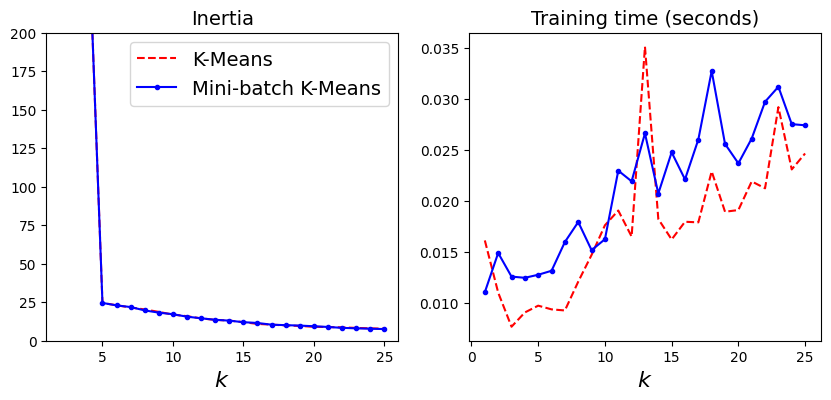

In [21]:
#@title Comparación de K-Means
X = visualizer.X
y = visualizer.y
times    = np.empty((25, 2))
inertias = np.empty((25, 2))
for k in range(1, 26):
    kmeans_          = KMeans(n_clusters=k, random_state=42,n_init='auto')
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42,n_init='auto')
    print("\r{}/{}".format(k, 25), end="")
    times[k-1, 0]    = timeit("kmeans_.fit(X)", number=2, globals=globals())
    times[k-1, 1]    = timeit("minibatch_kmeans.fit(X)", number=2, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 26), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 26), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 26, 0, 200])

plt.subplot(122)
plt.plot(range(1, 26), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 26), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
#plt.axis([1, 26, 0, 25])

#save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

# Cómo encontrar el número de grupos?

- **TIP:** Quizás estemos pensando que podríamos **elegir el modelo con la menor inercia**.

- **Respuesta:** Lamentablemente, no es tan simple. La inercia no es una buena medida de rendimiento cuando se trata de elegir $k$, ya que sigue disminuyendo a medida que aumentamos $k$. De hecho, cuantos más grupos haya, más cerca estará cada instancia de su centroide más cercano.

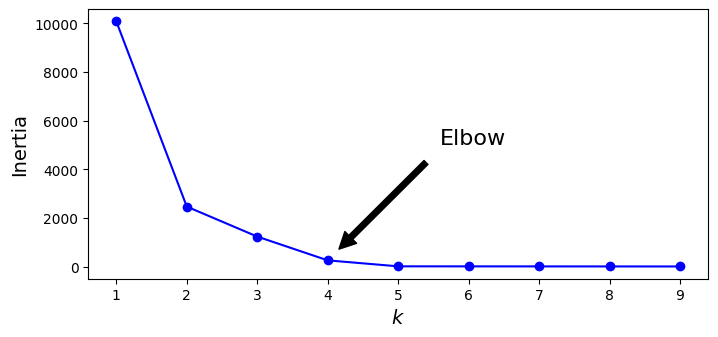

In [22]:
# @title Inertia vs. K

kmeans_per_k = [KMeans(n_clusters=k, random_state=42,n_init='auto').fit(X)
                for k in range(1, 10)]
inertias     = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

#save_fig("inertia_vs_k_plot")
plt.show()

- Como podemos ver, la inercia cae muy rápidamente a medida que aumentamos $k$ hasta 4, pero luego disminuye mucho más lentamente a medida que seguimos aumentando $k$.
- Esta curva tiene aproximadamente la forma de un brazo, y hay un "*codo*" en $k = 4$, por lo que si no lo supiéramos mejor, sería una buena opción: cualquier valor más bajo sería dramático, mientras que cualquier valor más alto no ayudaría mucho.

- Una altenativata a la inercia, es el *silhouette score*, como versión normalizada por grupo del concepto de inercia.

- Puede usar la función *silhouette_score()* de Scikit-Learn, dándole todas las instancias en el conjunto de datos y las etiquetas que se les asignaron.

Tracemos la puntuación de la silueta en función de $k$:

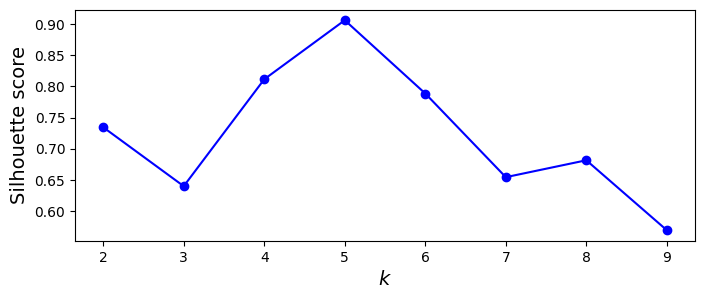

In [23]:
#@title Silhouette Score vs. K
kmeans=kmeans_good_.kmeans
silhouette_score(X, kmeans.labels_)
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7])
#save_fig("silhouette_score_vs_k_plot")
plt.show()

- Como podemos ver, aunque **confirma que $k = 4$ es una muy buena opción, también subraya el hecho de que $k = 5$ también es bastante bueno y mucho mejor que $k = 6$ o $k = 7$**.

Adicionalmente, obtenemos una visualización aún más informativa cuando trazamos el *silhouette score* de cada instancia, ordenado por el grupo al que están asignados y por el valor del coeficiente (**diagrama de silueta**):

In [24]:
# @title Silhouette Plot
# Generar los datos X (esto es solo un ejemplo, reemplázalo con tus datos si es necesario)
X = visualizer.X
# Crear un Output widget para la gráfica
output = Output()

# Función para actualizar la gráfica basada en el valor de k seleccionado
def plot_silhouette(k):
    with output:
        clear_output(wait=True)  # Limpiar la salida antes de actualizar la gráfica

        # Crear y ajustar el modelo KMeans para el valor de k seleccionado
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)

        # Obtener las etiquetas y los coeficientes de silueta para el valor de k seleccionado
        y_pred = kmeans.labels_
        silhouette_coefficients = silhouette_samples(X, y_pred)

        # Variables para manejar la posición y los ticks de los clusters
        plt.figure(figsize=(7, 5))
        padding = len(X) // 30
        pos = padding
        ticks = []

        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = mpl.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        # Configurar ejes y etiquetas
        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        plt.ylabel("Cluster")
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
        plt.axvline(x=np.mean(silhouette_coefficients), color="red", linestyle="--")
        plt.title(f"Silhouette Analysis for k={k}", fontsize=16)
        plt.show()

# Widget para seleccionar el valor de k
k_slider = IntSlider(min=2, max=9, step=1, value=3, description='Select k:', style={'description_width': 'initial'})

# Conectar el slider con la función de actualización de la gráfica
k_slider.observe(lambda change: plot_silhouette(change['new']), names='value')

# Mostrar el slider y la gráfica
display(VBox([k_slider, output]))

# Mostrar la gráfica inicial
plot_silhouette(k_slider.value)


- Las líneas discontinuas verticales representan el *silhouette score* por grupo.
- Cuando la mayoría de las instancias en un grupo tienen un coeficiente más bajo que este puntaje (es decir, si muchas de las instancias se detienen cerca de la línea punteada, terminando a la izquierda de la misma), entonces **el grupo es bastante malo, sus instancias están demasiado cerca de otros grupos**.
- Podemos ver que cuando $k = 3$ y cuando $k = 6$, obtenemos grupos defectuosos. Pero cuando $k = 4$ o $k = 5$, los grupos se ven bastante bien: **la mayoría de los casos se extienden más allá de la línea discontinua, a la derecha y más cerca de 1.0**.
- Cuando $k = 4$, el grupo en el índice 1 (el tercero desde la parte superior), es bastante grande, mientras que cuando $k = 5$, todos los grupos tienen tamaños similares, por lo que a pesar de que la puntuación de silueta general de $k = 4$ es ligeramente mayor que para $k = 5$, parece una buena idea usar $k = 5$ para obtener **grupos de tamaños similares**.

### Consideraciones sobre K-Means

**Ejemplo:** la Figura a continuación muestra cómo KMeans agrupa un conjunto de datos que contiene tres grupos elipsoidales de diferentes dimensiones, densidades y orientaciones:

In [25]:
#@title Datos de prueba
# Generación inicial de datos para X1 y X2
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

class BlobVisualizer1:
    def __init__(self):
        self.X1 = X1
        self.y1 = y1
        self.X2 = X2
        self.y2 = y2

    def plot_clusters(self, n_samples1, n_samples2, std1, std2):
        # Generar nuevos datos basados en los parámetros seleccionados
        X1, y1 = make_blobs(n_samples=n_samples1, centers=((4, -4), (0, 0)), cluster_std=std1, random_state=42)
        X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
        X2, y2 = make_blobs(n_samples=n_samples2, centers=1, cluster_std=std2, random_state=42)
        X2 = X2 + [6, -8]

        X = np.r_[X1, X2]
        y = np.r_[y1, y2]

        # Gráfica de los clusters
        plt.figure(figsize=(8, 4))
        plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
        plt.xlabel("$x_1$", fontsize=14)
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
        plt.title("Interactive Cluster Visualization")
        plt.show()
        self.X=X

        self.y=y

# Instanciar la clase visualizadora
visualizer = BlobVisualizer1()

# Uso de interact con la instancia del visualizador
interact(
    visualizer.plot_clusters,
    n_samples1=IntSlider(min=100, max=2000, step=100, value=1000, description='Samples Blob 1:'),
    n_samples2=IntSlider(min=50, max=1000, step=50, value=250, description='Samples Blob 2:'),
    std1=FloatSlider(min=0.05, max=1.0, step=0.05, value=0.6, description='Std Blob 1:'),
    std2=FloatSlider(min=0.05, max=1.0, step=0.05, value=0.4, description='Std Blob 2:')
)


interactive(children=(IntSlider(value=1000, description='Samples Blob 1:', max=2000, min=100, step=100), IntSl…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [26]:
# @title K-Means
X=visualizer.X
y=visualizer.y
class KMeansInteractive:
    def __init__(self, X):
        self.X = X
        self.kmeans = None
        self.y_pred = None
        self.output = Output()  # Output widget para los gráficos

    def train_kmeans(self, n_clusters, init_method, n_init, max_iter, algorithm):
        with self.output:
            clear_output(wait=True)  # Limpia la salida antes de mostrar nuevos resultados
            self.kmeans = KMeans(
                n_clusters=n_clusters,
                init=init_method,
                n_init=n_init,
                max_iter=max_iter,
                algorithm=algorithm,
                random_state=42
            )
            self.kmeans.fit(self.X)
            self.y_pred = self.kmeans.predict(self.X)
            self.plot_decision_boundaries()

    def plot_decision_boundaries(self):
        plt.figure(figsize=(8, 4))
        mins = self.X.min(axis=0) - 1
        maxs = self.X.max(axis=0) + 1
        xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000), np.linspace(mins[1], maxs[1], 1000))
        Z = self.kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.3, cmap="Pastel2")
        plt.contour(xx, yy, Z, linewidths=1, colors='k')
        self.plot_data()
        self.plot_centroids()
        plt.xlabel("$x_1$", fontsize=14)
        plt.ylabel("$x_2$", fontsize=14)
        plt.show()
        print(X.shape)

    def plot_data(self):
        plt.plot(self.X[:, 0], self.X[:, 1], 'k.', markersize=2)

    def plot_centroids(self):
        centroids = self.kmeans.cluster_centers_
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=30, linewidths=8,
                    color='w', zorder=10, alpha=0.9)
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=50, linewidths=3,
                    color='k', zorder=11, alpha=1)

# Widgets para los hiperparámetros
n_clusters_slider = IntSlider(min=2, max=10, step=1, value=5, description='n_clusters:', style={'description_width': 'initial'})
init_dropdown = Dropdown(options=['k-means++', 'random'], value='random', description='Init Method:', style={'description_width': 'initial'})
n_init_slider = IntSlider(min=1, max=20, step=1, value=5, description='n_init:', style={'description_width': 'initial'})
max_iter_slider = IntSlider(min=1, max=1000, step=1, value=10, description='max_iter:', style={'description_width': 'initial'})
algorithm_dropdown = Dropdown(options=['lloyd', 'elkan'], value='lloyd', description='Algorithm:', style={'description_width': 'initial'})

train_button = Button(description="Train KMeans")
kmeans_interactive = KMeansInteractive(X)  # Instancia de la clase

def on_train_button_clicked(b):
   kmeans_interactive.train_kmeans(
        n_clusters_slider.value, init_dropdown.value,
        n_init_slider.value, max_iter_slider.value, algorithm_dropdown.value
    )

train_button.on_click(on_train_button_clicked)
ui = VBox([n_clusters_slider, init_dropdown, n_init_slider, max_iter_slider, algorithm_dropdown, train_button],
          layout=Layout(display='flex', flex_flow='column', align_items='stretch'))
display(ui, kmeans_interactive.output)


Output()

Como podemos ver, **ninguna de estas soluciones es buena**.

Entonces, dependiendo de los datos, los diferentes algoritmos de agrupación pueden funcionar mejor. Por ejemplo, en estos tipos de grupos elípticos, los **modelos de mezcla gaussiana** funcionan muy bien.

**TIP:** Es importante **escalar las características de entrada antes de ejecutar K-Means**, de lo contrario, los grupos pueden estar muy extendidos y K-Means funcionará mal. Escalar las características no garantiza que todos los clústeres sean agradables y esféricos, pero generalmente mejora las cosas.

## DBSCAN

Las etiquetas de todas las instancias ahora están disponibles en la variable *labels_ instance*:

- Tenga en cuenta que algunas instancias tienen un índice de clúster igual a **-1**: esto significa que **el algoritmo las considera anomalías**.

- Los índices de las instancias centrales están disponibles en la variable de instancia *core_sample_indices_*, y las propias instancias centrales están disponibles en la variable *components_ instance*:

Sorprendentemente, la clase **DBSCAN** no tiene un método *predict_()*, aunque tiene un método *fit_predict_()*. En otras palabras, no puede predecir a qué clúster pertenece una nueva instancia. La razón de esta decisión es que varios algoritmos de clasificación podrían tener sentido aquí, y es bastante fácil entrenar uno, por ejemplo, un clasificador K-NN:

- Ahora, dadas algunas instancias nuevas, **podemos predecir a qué grupo probablemente pertenecerán**, e incluso **estimar una probabilidad para cada grupo**.
- Tengamos en cuenta que solo los entrenamos en las instancias centrales, pero también podríamos haber optado por usar **todas las instancias**, o **todas menos las anomalías**: esta elección depende de la tarea final.

### Spectral clustering

-  Es crucial sintonizar la medida de similitud (kernel), para codificar las nolinealidades de los datos.

In [27]:
#@title Comparación
# Generate dataset
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

class ClusteringInteractive:
    def __init__(self, X):
        self.X = X
        self.clusterer = None
        self.y_pred = None
        self.output = Output()  # Output widget para los gráficos

    def train_kmeans(self, n_clusters, init_method, n_init, max_iter, algorithm):
        with self.output:
            clear_output(wait=True)
            self.clusterer = KMeans(
                n_clusters=n_clusters,
                init=init_method,
                n_init=n_init,
                max_iter=max_iter,
                algorithm=algorithm,
                random_state=42
            )
            self.clusterer.fit(self.X)
            self.y_pred = self.clusterer.predict(self.X)
            self.plot_decision_boundaries()

    def train_dbscan(self, eps, min_samples):
        with self.output:
            clear_output(wait=True)
            self.clusterer = DBSCAN(eps=eps, min_samples=min_samples)
            self.y_pred = self.clusterer.fit_predict(self.X)
            self.plot_clusters()

    def train_spectral(self, n_clusters, gamma):
        with self.output:
            clear_output(wait=True)
            self.clusterer = SpectralClustering(n_clusters=n_clusters, gamma=gamma, random_state=42)
            self.y_pred = self.clusterer.fit_predict(self.X)
            self.plot_clusters()

    def plot_decision_boundaries(self):
        plt.figure(figsize=(8, 4))
        mins = self.X.min(axis=0) - 1
        maxs = self.X.max(axis=0) + 1
        xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000), np.linspace(mins[1], maxs[1], 1000))
        Z = self.clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.3, cmap="Pastel2")
        plt.contour(xx, yy, Z, linewidths=1, colors='k')
        self.plot_data()
        self.plot_centroids()
        plt.xlabel("$x_1$", fontsize=14)
        plt.ylabel("$x_2$", fontsize=14)
        plt.show()

    def plot_clusters(self):
        plt.figure(figsize=(8, 4))
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y_pred, s=10, cmap="Paired")
        plt.xlabel("$x_1$", fontsize=14)
        plt.ylabel("$x_2$", fontsize=14)
        plt.title(f"Clusters found: {len(np.unique(self.y_pred))}")
        plt.show()

    def plot_data(self):
        plt.plot(self.X[:, 0], self.X[:, 1], 'k.', markersize=2)

    def plot_centroids(self):
        if hasattr(self.clusterer, 'cluster_centers_'):
            centroids = self.clusterer.cluster_centers_
            plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=30, linewidths=8,
                        color='w', zorder=10, alpha=0.9)
            plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=50, linewidths=3,
                        color='k', zorder=11, alpha=1)

# Instancia de la clase interactiva
clustering_interactive = ClusteringInteractive(X)

# Widgets para KMeans
n_clusters_slider = IntSlider(min=2, max=10, step=1, value=5, description='n_clusters:')
init_dropdown = Dropdown(options=['k-means++', 'random'], value='random', description='Init Method:')
n_init_slider = IntSlider(min=1, max=20, step=1, value=10, description='n_init:')
max_iter_slider = IntSlider(min=10, max=1000, step=10, value=300, description='max_iter:')
algorithm_dropdown = Dropdown(options=['lloyd', 'elkan'], value='lloyd', description='Algorithm:')

# Widgets para DBSCAN
eps_slider = FloatSlider(min=0.05, max=0.15, step=0.01, value=0.06, description='eps:')
min_samples_slider = IntSlider(min=1, max=20, step=1, value=5, description='min_samples:')

# Widgets para Spectral Clustering
gamma_slider = FloatSlider(min=1, max=15, step=1, value=1, description='gamma:')
n_clusters_spectral_slider = IntSlider(min=2, max=10, step=1, value=2, description='n_clusters:')

# Selector de modelo
model_dropdown = Dropdown(options=['KMeans', 'DBSCAN', 'Spectral Clustering'], value='KMeans', description='Model:')

# Mostrar y ocultar widgets según el modelo seleccionado
def on_model_change(change):
    if change['new'] == 'KMeans':
        kmeans_box.layout.display = 'flex'
        dbscan_box.layout.display = 'none'
        spectral_box.layout.display = 'none'
    elif change['new'] == 'DBSCAN':
        kmeans_box.layout.display = 'none'
        dbscan_box.layout.display = 'flex'
        spectral_box.layout.display = 'none'
    elif change['new'] == 'Spectral Clustering':
        kmeans_box.layout.display = 'none'
        dbscan_box.layout.display = 'none'
        spectral_box.layout.display = 'flex'

model_dropdown.observe(on_model_change, names='value')

# Cajas de control para cada método de clustering
kmeans_box = VBox([n_clusters_slider, init_dropdown, n_init_slider, max_iter_slider, algorithm_dropdown], layout=Layout(display='flex', flex_flow='column'))
dbscan_box = VBox([eps_slider, min_samples_slider], layout=Layout(display='none', flex_flow='column'))
spectral_box = VBox([n_clusters_spectral_slider, gamma_slider], layout=Layout(display='none', flex_flow='column'))

# Funciones para interactuar con los sliders y dropdowns
def update_kmeans(n_clusters, init_method, n_init, max_iter, algorithm):
    clustering_interactive.train_kmeans(n_clusters, init_method, n_init, max_iter, algorithm)

def update_dbscan(eps, min_samples):
    clustering_interactive.train_dbscan(eps, min_samples)

def update_spectral(n_clusters, gamma):
    clustering_interactive.train_spectral(n_clusters, gamma)

# Uso de interactive_output para actualizar gráficos en tiempo real
interactive_kmeans = interactive_output(update_kmeans, {
    'n_clusters': n_clusters_slider,
    'init_method': init_dropdown,
    'n_init': n_init_slider,
    'max_iter': max_iter_slider,
    'algorithm': algorithm_dropdown
})

interactive_dbscan = interactive_output(update_dbscan, {
    'eps': eps_slider,
    'min_samples': min_samples_slider
})

interactive_spectral = interactive_output(update_spectral, {
    'n_clusters': n_clusters_spectral_slider,
    'gamma': gamma_slider
})

# Contenedor principal
ui = VBox([
    model_dropdown,
    kmeans_box,
    dbscan_box,
    spectral_box,
    clustering_interactive.output,
    interactive_kmeans,
    interactive_dbscan,
    interactive_spectral
], layout=Layout(display='flex', flex_flow='column', align_items='stretch', width='400px'))

display(ui)
